## Training Functions

## SHD

In [2]:
import torch
import torch.nn as nn
from aihwkit.nn import AnalogLinear
from aihwkit.simulator.presets import EcRamPreset
from aihwkit.simulator.configs.devices import LinearStepDevice
from aihwkit.optim import AnalogSGD
import matplotlib.pyplot as plt
import numpy as np

rpu_config = EcRamPreset()
#rpu_config = LinearStepDevice()

# rpu_config.device.gamma_up = 0.01153
# rpu_config.device.gamma_down = 0.05085


# Define two parallel networks
class Network(nn.Module):
    def __init__(self, device='cpu', rpu_config=rpu_config):
        super(Network, self).__init__()
        self.l1 = AnalogLinear(1, 1, bias=False, rpu_config=rpu_config).to(device)

    def forward(self, x):
        x = self.l1(x)
        return x

model = Network()
   
for param in model.parameters():
    analog_tile = param.analog_tile
    # Access the TransferCompound device
    device_weights = analog_tile.get_hidden_parameters()
    for key, value in device_weights.items():
        print(f"{key}: {value}")

max_bound: tensor([[1.1673]])
min_bound: tensor([[-0.8879]])
dwmin_up: tensor([[0.0022]])
dwmin_down: tensor([[0.0023]])
decay_scales: tensor([[1.]])
diffusion_rates: tensor([[0.]])
reset_bias: tensor([[0.]])
drift_nu: tensor([[0.]])
slope_up: tensor([[-0.0003]])
slope_down: tensor([[0.0016]])


In [3]:
params = model.l1.analog_module.get_hidden_parameters()
params

OrderedDict([('max_bound', tensor([[1.1673]])),
             ('min_bound', tensor([[-0.8879]])),
             ('dwmin_up', tensor([[0.0022]])),
             ('dwmin_down', tensor([[0.0023]])),
             ('decay_scales', tensor([[1.]])),
             ('diffusion_rates', tensor([[0.]])),
             ('reset_bias', tensor([[0.]])),
             ('drift_nu', tensor([[0.]])),
             ('slope_up', tensor([[-0.0003]])),
             ('slope_down', tensor([[0.0016]]))])

Text(0, 0.5, 'Logical value of w')

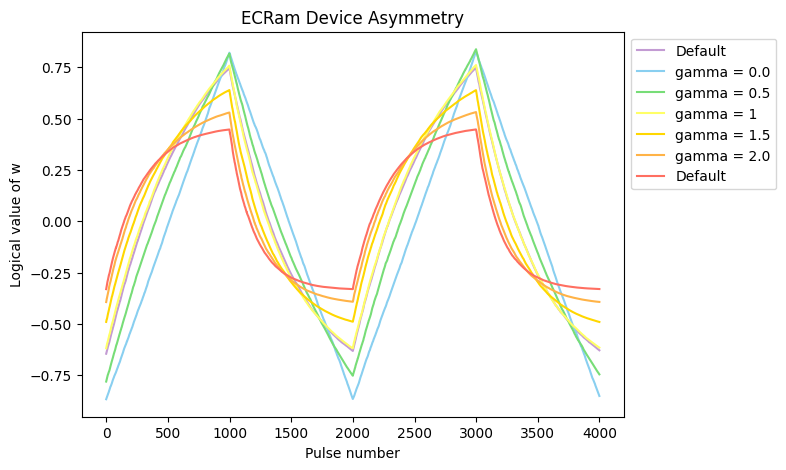

In [ ]:
sym_index = [-1, 0.0, 0.5, 1, 1.5, 2.0, 2.5]
colors = ['#C39BD3','#89CFF0','#77DD77','#FFFF66', '#FFD700', '#FFB347','#FF6F61']
rpu_config = EcRamPreset()
rpu_config.device.construction_seed = 1
plt.figure(figsize=(7, 5))
for si in sym_index:
    if si >= 0:
        rpu_config.device.gamma_up = si
        rpu_config.device.gamma_down = si
    model = Network(rpu_config=rpu_config)
    optimizer = AnalogSGD(model.parameters(), lr=0.002)
    params = model.l1.analog_module.get_hidden_parameters()
    model.l1.set_weights(params['min_bound'])
    w_A = []

    for i in range(6000):
        if i < 1000 or i > 2000 and i < 3000 or i > 4000 and i < 5000:
            y = model(torch.tensor([[1.0]]))
            l = (1 - y)
        else:
            y = model(torch.tensor([[1.0]]))
            l = y

        l.backward()
        optimizer.step()
        optimizer.zero_grad()
        params = model.l1.analog_module.get_hidden_parameters()
        if i >= 2000:
            w_A.append(model.l1.get_weights()[0].detach().item())
    plt.plot(w_A, color=colors.pop(0), label=f"gamma = {si}" if si >= 0 else "Default")
    
plt.legend(loc='upper left', bbox_to_anchor=(1, 1))
plt.title('ECRam Device Asymmetry')
    
plt.xlabel('Pulse number')
plt.ylabel('Logical value of w')

Text(0.25, 0.8, 'MIT Protonic\nSynapse')

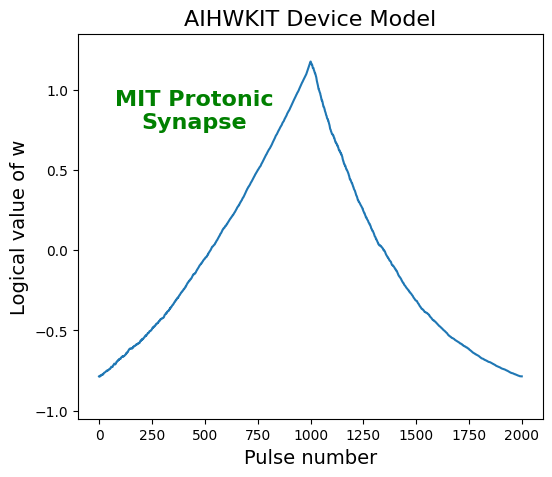

In [8]:
rpu_config = EcRamPreset()
rpu_config.device.gamma_up = -0.38
rpu_config.device.gamma_down = 0.76
rpu_config.device.construction_seed = 45
plt.figure(figsize=(6, 5),dpi=100)
model = Network(rpu_config=rpu_config)
optimizer = AnalogSGD(model.parameters(), lr=0.0025)
params = model.l1.analog_module.get_hidden_parameters()
model.l1.set_weights(params['min_bound'])
w_A = []

for i in range(4000):
    if i < 1000 or i > 2000 and i < 3000:
        y = model(torch.tensor([[1.0]]))
        l = (1 - y)
    else:
        y = model(torch.tensor([[1.0]]))
        l = y

    l.backward()
    optimizer.step()
    optimizer.zero_grad()
    params = model.l1.analog_module.get_hidden_parameters()
    if i >= 2000:
        w_A.append(model.l1.get_weights()[0].detach().item())

# Mirror the first half of the data points
midpoint = len(w_A) // 2
first_half = w_A[:midpoint]
second_half = w_A[midpoint:]

# Calculate the line to mirror against
start_val = w_A[0]
peak_val = w_A[midpoint]
mirror_line = np.linspace(start_val, peak_val, midpoint)

# Mirror the first half
mirrored_first_half = 2 * mirror_line - first_half

# Combine the mirrored first half with the original second half
w_A_mirrored = np.concatenate([mirrored_first_half, second_half])

plt.plot(w_A_mirrored)
plt.title('AIHWKIT Device Model', fontsize=16)
plt.xlabel('Pulse number', fontsize=14)
plt.ylabel('Logical value of w', fontsize=14)
plt.ylim(-1.05, 1.35)

# place text in the middle of the plot
plt.text(0.25, 0.8, 'MIT Protonic\nSynapse', fontsize=16, ha='center', va='center', transform=plt.gca().transAxes, color='green', weight='bold')

## Training

In [5]:
from IPython.display import clear_output

def test_evaluation(model, val_set, classifier):
    """Test trained network

    Args:
        model (nn.Model): Trained model to be evaluated
        val_set (DataLoader): Validation set to perform the evaluation
    """
    # Setup counter of images predicted to 0.
    total_loss = 0
    predicted_ok = 0
    total_images = 0

    model.digital_evaluation()

    for images, labels in val_set:
        images = images.view(images.shape[0], -1)
        pred = model(images)

        loss = classifier(pred, labels)

        total_loss += loss.item() * labels.size(0)
        _, predicted = torch.max(pred.data, 1)
        total_images += labels.size(0)
        predicted_ok += (predicted == labels).sum().item()

    accuracy = predicted_ok / total_images
    loss = total_loss / total_images
    return loss, accuracy

def training_run(train_set, validation_set, model, optimizer, scheduler, loss_fn, epochs):

    l = []
    a = []
    # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
    # neuron = 0
    # weight = 0
    # num_tiles = model.l1.tile.num_tiles

    # params = model.l1.get_hidden_parameters()
    # w_C = [[params[f'slow_weight_{i}'][neuron][weight].item() for i in range(1, num_tiles + 1)]]
    # w_A = [params['fast_weight'][neuron][weight].item()]

    
    for e in range(epochs):
        model.train()

        for x, y_true in train_set:
            # Flatten MNIST images into a 784 vector.
            x = x.view(x.shape[0], -1)

            output = model(x)
            loss = loss_fn(output, y_true)

            # backward pass
            loss.backward()

            # update params
            optimizer.step()
            optimizer.zero_grad()

            # save in a list the historical values of a weight of dense2_C and the same neuron in dense2_A
            # params = model.l1.get_hidden_parameters()
            # w_C.append([params[f'slow_weight_{i}'][neuron][weight].item() for i in range(1, num_tiles + 1)])
            # w_A.append(params['fast_weight'][neuron][weight].item())

        loss, acc = test_evaluation(model, validation_set, loss_fn)
        l.append(loss)
        a.append(acc)

        # Decay learning rate if needed.
        # if acc > 0.90 and scheduler.get_last_lr()[0] >= 0.1 \
        #     or acc > 0.95 and scheduler.get_last_lr()[0] >= 0.05:
        #     print("Decaying learning rate from {} to {}".format(scheduler.get_last_lr()[0], scheduler.get_last_lr()[0] * 0.5))
        #     scheduler.step()

        if (e+1) % 1 == 0:
            clear_output(wait=True)
            plt.plot(l)
            plt.title(f'Final Loss: {np.mean(l[-1:]):.2f}')
            plt.xlabel('Epoch')
            plt.ylabel('Loss')
            plt.show()
            if a != []:
                plt.plot(a)
                plt.title(f'Final Accuracy: {np.mean(a[-1:]):.2f}')
                plt.xlabel('Epoch')
                plt.ylabel('Accuracy')
                plt.show()
        
        if np.isnan(l[-1]):
            break

    return l, a#, w_C, w_A


### MNIST


In [13]:
from aihwkit.simulator.tiles.transfer_for_batched_TTv2 import TorchTransferTile
from aihwkit.optim import AnalogSGD
import torch.nn as nn
from aihwkit.nn import AnalogLinear
from aihwkit.simulator.presets import AGADEcRamPreset
from torch.optim.lr_scheduler import StepLR

# Network definition.
INPUT_SIZE = 784
HIDDEN_SIZES = [256, 128]
OUTPUT_SIZE = 10

class Analog_Network(nn.Module):

    def __init__(self, rpu_config, t = [1,1,1], init_std=0.0):
        super(Analog_Network, self).__init__()

        rpu_config.device.units_in_mbatch = True
        rpu_config.mapping.learn_out_scaling = True
        rpu_config.device.transfer_every = t[0]
        self.l1 = TorchTransferTile(
            INPUT_SIZE,
            HIDDEN_SIZES[0],
            rpu_config,
            True,
        )
        rpu_config.device.transfer_every = t[1]
        self.l2 = TorchTransferTile(
            HIDDEN_SIZES[0],
            HIDDEN_SIZES[1],
            rpu_config,
            True,
        )
        rpu_config.device.transfer_every = t[2]
        self.l3 = TorchTransferTile(
            HIDDEN_SIZES[1],
            OUTPUT_SIZE,
            rpu_config,
            True,
        )
        self.logsoftmax = nn.LogSoftmax(dim=1)

        # self.l1.set_scales(torch.tensor([5.0]))
        # self.l2.set_scales(torch.tensor([5.0]))
        # self.l3.set_scales(torch.tensor([3.0]))

        if init_std >= 0:
            batch_size = self.l1.rpu_config.batch_size
            # initialize weights  
            init_w = self.l1.get_weights()[0][0]
            noisy_weights = [torch.normal(mean=init_w, std=init_std) for _ in range(batch_size)]
            params = self.l1.get_hidden_parameters()
            params.update({f'slow_weight_{i+1}': noisy_weights[i] for i in range(batch_size)})
            params.update({f'fast_weight': torch.zeros_like(init_w)})
            #params.update({f'fast_weight_{i+1}': torch.zeros_like(init_w) for i in range(batch_size)})
            self.l1.set_hidden_parameters(params)

            init_w = self.l2.get_weights()[0][0]
            noisy_weights = [torch.normal(mean=init_w, std=init_std) for _ in range(batch_size)]
            params = self.l2.get_hidden_parameters()
            params.update({f'slow_weight_{i+1}': noisy_weights[i] for i in range(batch_size)})
            params.update({f'fast_weight': torch.zeros_like(init_w)})
            #params.update({f'fast_weight_{i+1}': torch.zeros_like(init_w) for i in range(batch_size)})
            self.l2.set_hidden_parameters(params)  

            init_w = self.l3.get_weights()[0][0]
            noisy_weights = [torch.normal(mean=init_w, std=init_std) for _ in range(batch_size)]
            params = self.l3.get_hidden_parameters()
            params.update({f'slow_weight_{i+1}': noisy_weights[i] for i in range(batch_size)})
            params.update({f'fast_weight': torch.zeros_like(init_w)})
            #params.update({f'fast_weight_{i+1}': torch.zeros_like(init_w) for i in range(batch_size)})
            self.l3.set_hidden_parameters(params)

        

    def digital_evaluation(self):
        self.digital_eval = True
        self.training = False

    def analog_evaluation(self):
        self.digital_eval = False
        self.training = False   

    def forward(self, x):
        if self.training:
            x = self.l1(x)
            x = torch.sigmoid(x)
            x = self.l2(x)
            x = torch.sigmoid(x)
            x = self.l3(x)
            x = self.logsoftmax(x)
            return x 
        else:
            with torch.no_grad():
                w_l1 = torch.mean(self.l1.get_weights()[0], dim=0)
                w_l2 = torch.mean(self.l2.get_weights()[0], dim=0)
                w_l3 = torch.mean(self.l3.get_weights()[0], dim=0)
                if  self.digital_eval:
                    self.l1_n = nn.Linear(INPUT_SIZE, HIDDEN_SIZES[0], bias=True).to(x.device)
                    self.l1_n.weight.data = w_l1
                    self.l1_n.bias.data = self.l1.get_weights()[1]
                    self.l2_n = nn.Linear(HIDDEN_SIZES[0], HIDDEN_SIZES[1], bias=True).to(x.device)
                    self.l2_n.weight.data = w_l2
                    self.l2_n.bias.data = self.l2.get_weights()[1]
                    self.l3_n = nn.Linear(HIDDEN_SIZES[1], OUTPUT_SIZE, bias=True).to(x.device)
                    self.l3_n.weight.data = w_l3
                    self.l3_n.bias.data = self.l3.get_weights()[1]
                else:
                    self.l1_n = AnalogLinear(INPUT_SIZE, HIDDEN_SIZES[0], bias=True, rpu_config=self.l1.rpu_config).to(x.device)
                    self.l1_n.set_weights(w_l1, bias=self.l1.get_weights()[1])
                    self.l2_n = AnalogLinear(HIDDEN_SIZES[0], HIDDEN_SIZES[1], bias=True, rpu_config=self.l2.rpu_config).to(x.device)
                    self.l2_n.set_weights(w_l2, bias=self.l2.get_weights()[1])
                    self.l3_n = AnalogLinear(HIDDEN_SIZES[1], OUTPUT_SIZE, bias=True, rpu_config=self.l3.rpu_config).to(x.device)
                    self.l3_n.set_weights(w_l3, bias=self.l3.get_weights()[1])

                x = self.l1_n(x)
                x = torch.sigmoid(x)
                x = self.l2_n(x)
                x = torch.sigmoid(x)
                x = self.l3_n(x)
                x = self.logsoftmax(x)
                return x 

In [7]:
from torchvision import datasets, transforms

# Path where the datasets will be stored.
PATH_DATASET = os.path.join("SHD_script/data", "DATASET")

def load_images(batch_size):
    """Load images for train from the torchvision datasets."""
    transform = transforms.Compose([transforms.ToTensor()])

    # Load the images.
    train_set = datasets.MNIST(PATH_DATASET, download=True, train=True, transform=transform)
    val_set = datasets.MNIST(PATH_DATASET, download=True, train=False, transform=transform)
    train_data = torch.utils.data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    validation_data = torch.utils.data.DataLoader(val_set, batch_size=batch_size, shuffle=True)

    return train_data, validation_data

In [8]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

batch_size = 128

rpu = AGADEcRamPreset()
rpu.device.fast_lr = 0.0128
rpu.batch_size = 16
t = [1,1,1]
rpu.forward.out_noise = 0.04
#rpu.forward.is_perfect = True

model = Analog_Network(rpu_config=rpu, t=t, init_std=0.01).to(device)

print(torch.max(model.l1.get_weights()[0]))

tensor(0.1443)


In [9]:
print(rpu)

AGADEcRamPreset(
    runtime=RuntimeParameter(),
    pre_post=PrePostProcessingParameter(input_range=InputRangeParameter(enable=False)),
    mapping=MappingParameter(learn_out_scaling=True),
    forward=PresetIOParameters(out_noise=0.04),
    backward=PresetIOParameters(),
    update=PresetUpdateParameters(),
    device=DynamicTransferCompound(
        unit_cell_devices=[
            EcRamPresetDevice(),
            EcRamPresetDevice()
        ],
        units_in_mbatch=True,
        fast_lr=0.0128,
        transfer_forward=PresetIOParameters(bound_management=BoundManagementType.NONE, noise_management=NoiseManagementType.NONE),
        transfer_update=PresetUpdateParameters(desired_bl=1, update_bl_management=False, update_management=False),
        in_chop_prob=0.005,
        auto_granularity=750,
        auto_scale=True,
        tail_weightening=50.0
    )
)


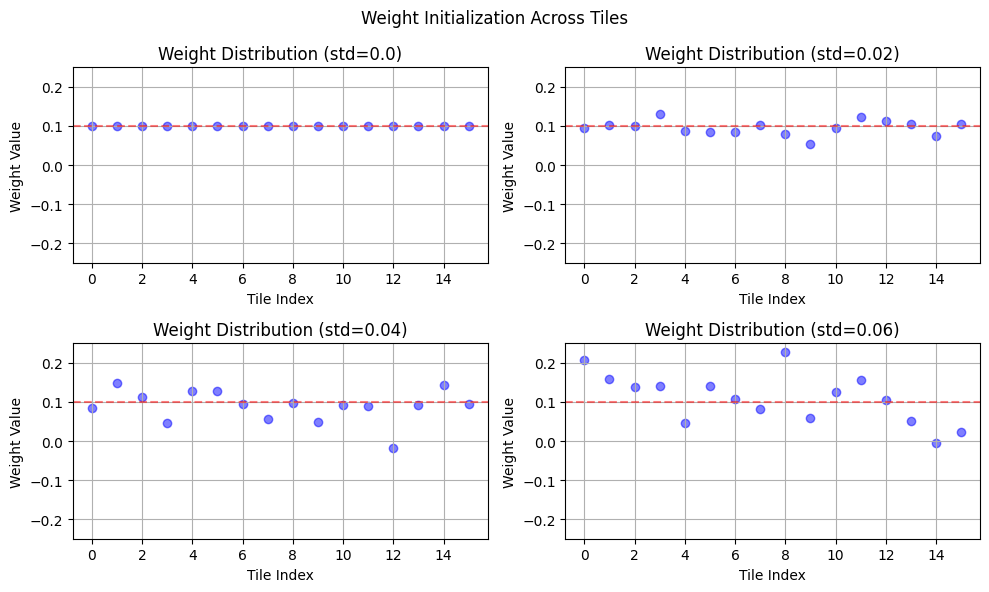

In [12]:
import matplotlib.pyplot as plt
import numpy as np

stds = [0.0, 0.02, 0.04, 0.06]

fig, axs = plt.subplots(2, 2, figsize=(10, 6))

for idx, std in enumerate(stds):
    model = Analog_Network(rpu_config=rpu, t=t, init_std=std).to(device)
    weights = model.l1.get_weights()[0][:, 0, 0]

    # Flatten the weights array
    weights_flat = weights.flatten()

    # Create a scatter plot of the weights
    ax = axs[idx // 2, idx % 2]
    x_values = np.arange(len(weights_flat))
    ax.line = ax.axhline(y=0.1, color='r', linestyle='--', alpha=0.5)
    ax.scatter(x_values, weights_flat, color='blue', alpha=0.5)
    ax.set_title(f'Weight Distribution (std={std})')
    ax.set_xlabel('Tile Index')
    ax.set_ylabel('Weight Value')
    ax.set_ylim(-0.25, 0.25)
    ax.grid(True)

# set title
plt.suptitle('Weight Initialization Across Tiles')
plt.tight_layout()
plt.show()

#### Grid search

In [13]:
# grid search for hyperparameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

batch_size = 64

train, eval = load_images(batch_size)

# grid search
learning_rate_C = [0.003, 0.03, 0.3]
learning_rate_A = [0.5, 1, 2, 4, 8]
t = [[1, 1, 1]]

best_loss = float('inf')
best_accuracy = 0
results = []

for lr_C in learning_rate_C:
    for lr_A in learning_rate_A:
            for t_ in t:
                l = []
                a = []
                for _ in range(1):
                    rpu = AGADEcRamPreset()
                    rpu.batch_size = 1
                    rpu.mapping.learn_out_scaling = True
                    rpu.device.fast_lr = lr * 1

                    model = Analog_Network(rpu_config=rpu, t=t_).to(device)
                    optimizer = AnalogSGD(model.parameters(), lr=lr)
                    optimizer.regroup_param_groups(model)

                    loss_fn = nn.NLLLoss()

                    loss, accuracy = training_run(train, model, optimizer, loss_fn, 10)
                    l.append(loss)
                    a.append(accuracy)
                #print(f'Loss: {loss:.2f}, accuracy: {accuracy:.2f} for params: lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}')
                results.append({
                    'lr_C': lr_C,
                    'lr_A': lr_A,
                    't': t_,
                    'loss': np.mean(l),
                    'accuracy': np.mean(a)
                })
                    # if loss < best_loss:
                    #     best_loss = loss
                    #     best_accuracy = accuracy
                    #     best_params = f'lr_C: {lr_C}, lr_A: {lr_A}, t: {t_}'

#print(f'Best loss: {best_loss}, best accuracy: {best_accuracy} for params: {best_params}')

NameError: name 'lr' is not defined

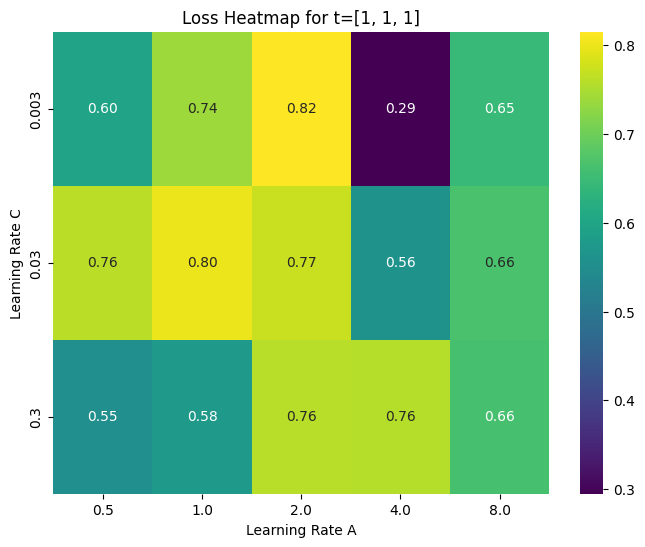

In [ ]:
import pandas as pd

# Convert results to DataFrame
df = pd.DataFrame(results)

import seaborn as sns
import matplotlib.pyplot as plt

# Filter by specific `t_` if needed
t_fixed = [1, 1, 1]  # Example
filtered_df = df[df['t'].apply(lambda x: x == t_fixed)]

# Pivot table for heatmap
heatmap_data = filtered_df.pivot(index="lr_C", columns="lr_A", values="accuracy")

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(heatmap_data, annot=True, fmt=".2f", cmap="viridis")
plt.title(f"Loss Heatmap for t={t_fixed}")
plt.xlabel("Learning Rate A")
plt.ylabel("Learning Rate C")
plt.show()

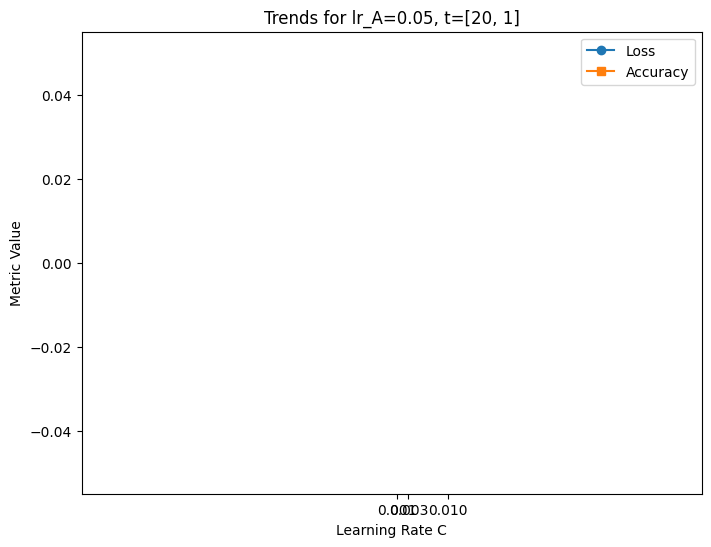

In [ ]:
# Example: Plot loss vs lr_C for a fixed lr_A and t
lr_A_fixed = 0.05
t_fixed = [1, 1]

filtered_df = df[(df['lr_A'] == lr_A_fixed) & (df['t'].apply(lambda x: x == t_fixed))]

plt.figure(figsize=(8, 6))
plt.plot(filtered_df['lr_C'], filtered_df['loss'], marker='o', label="Loss")
plt.plot(filtered_df['lr_C'], filtered_df['accuracy'], marker='s', label="Accuracy")
plt.xlabel("Learning Rate C")
plt.ylabel("Metric Value")
plt.xticks(learning_rate_C)
plt.title(f"Trends for lr_A={lr_A_fixed}, t={t_fixed}")
plt.legend()
plt.show()

#### Run

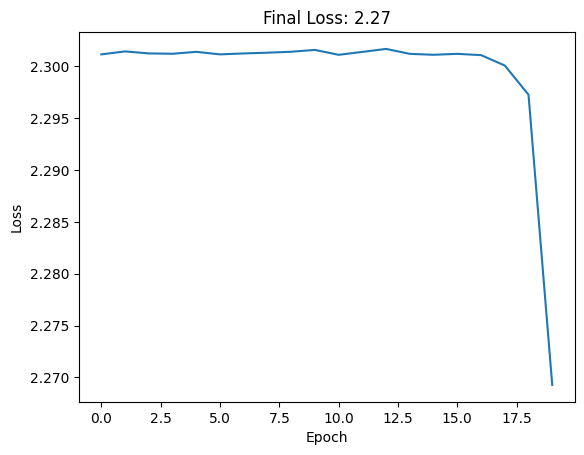

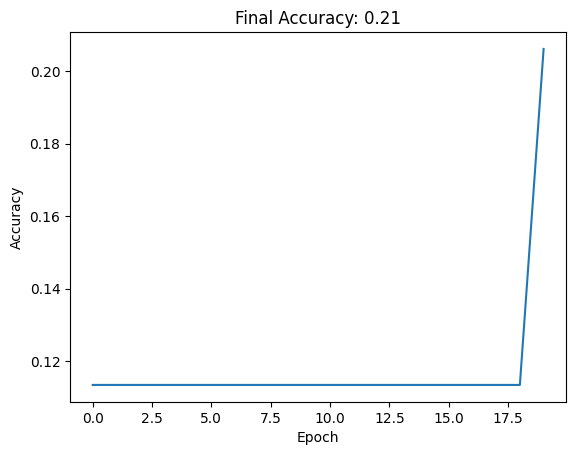

In [16]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

batch_size = 64

train, eval = load_images(batch_size)

lr = 0.1 #* 31 #* batch_size

rpu = AGADEcRamPreset()
rpu.device.fast_lr = lr 
#rpu.device.in_chop_prob = 0.001
rpu.batch_size = 4
t = [1, 1, 1]

# rpu.forward.out_noise = 0.0
# rpu.device.transfer_forward.out_noise = 0.0
# rpu.forward.is_perfect = True
rpu.update.desired_bl = 31

model = Analog_Network(rpu_config=rpu, t=t, init_std=-1).to(device)
optimizer = AnalogSGD(model.parameters(), lr=lr)
optimizer.regroup_param_groups(model)
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

loss_fn = nn.NLLLoss()

loss, accuracy = training_run(train, eval, model, optimizer, scheduler, loss_fn, 20)

In [23]:
print(np.mean(model.l1.tile.max_pulses))
print(np.mean(model.l2.tile.max_pulses))
print(np.mean(model.l3.tile.max_pulses))

print(np.min(model.l1.tile.max_pulses))
print(np.min(model.l2.tile.max_pulses))
print(np.min(model.l3.tile.max_pulses))

1.0
1.0
1.0
1.0
1.0
1.0


In [18]:
model.l1.get_scales(), model.l2.get_scales(), model.l3.get_scales()

(Parameter containing:
 tensor([6.1484], requires_grad=True),
 Parameter containing:
 tensor([6.3190], requires_grad=True),
 Parameter containing:
 tensor([4.1271], requires_grad=True))

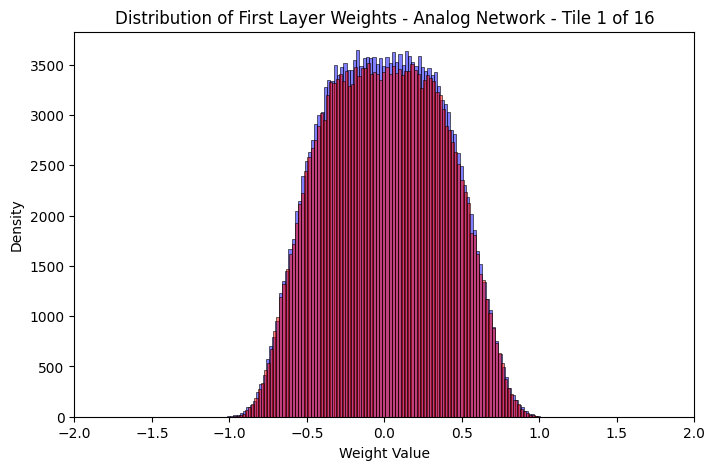

In [17]:
import torch
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'model' is your PyTorch model
first_tile_first_layer_weights = model.l1.get_weights()[0][1].numpy().flatten()
actual_weights = model.l1_n.weight.detach().numpy().flatten()

# Create the distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(first_tile_first_layer_weights, kde=True, bins=100, color='blue', line_kws={'linewidth': 0})
sns.histplot(actual_weights, kde=True, bins=100, color='red', line_kws={'linewidth': 0})
plt.title('Distribution of First Layer Weights - Analog Network - Tile 1 of 16')
plt.xlabel('Weight Value')
plt.ylabel('Density')
plt.xlim(-2, 2)
plt.show()


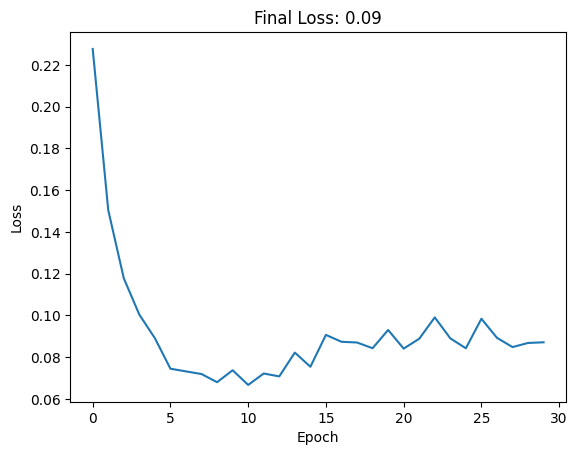

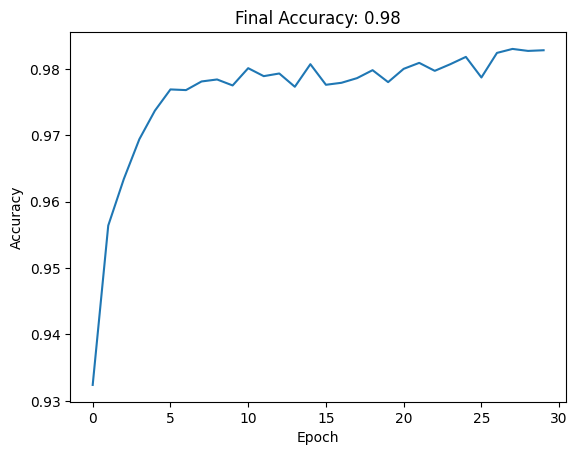

In [17]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device = 'cpu'

batch_size = 64

train, eval = load_images(batch_size)

## train using adam
class Digital_Network(nn.Module):
    
    def __init__(self):
        super(Digital_Network, self).__init__()

        self.l1 = nn.Linear(INPUT_SIZE, HIDDEN_SIZES[0])
        self.l2 = nn.Linear(HIDDEN_SIZES[0], HIDDEN_SIZES[1])
        self.l3 = nn.Linear(HIDDEN_SIZES[1], OUTPUT_SIZE)
        self.logsoftmax = nn.LogSoftmax(dim=1)
    
    def digital_evaluation(self):
        pass

    def forward(self, x):
        x = self.l1(x)
        x = torch.sigmoid(x)
        x = self.l2(x)
        x = torch.sigmoid(x)
        x = self.l3(x)
        x = self.logsoftmax(x)
        return x
    
model = Digital_Network().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn = nn.NLLLoss()
scheduler = StepLR(optimizer, step_size=1, gamma=0.5)

loss_d, accuracy_d = training_run(train, eval, model, optimizer, scheduler, loss_fn, 30)

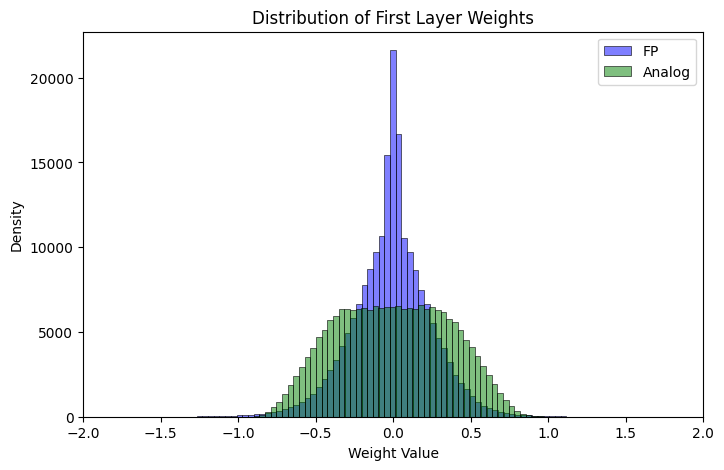

In [25]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'model' is your PyTorch model
first_layer_weights = model.l1.weight.data.numpy().flatten()

# Create the distribution plot
plt.figure(figsize=(8, 5))
sns.histplot(first_layer_weights, kde=True, bins=100, color='blue', line_kws={'linewidth': 0}, label='FP', alpha=0.5)
sns.histplot(first_tile_first_layer_weights, kde=True, bins=56, color='green', line_kws={'linewidth': 0}, label='Analog', alpha=0.5)

plt.title('Distribution of First Layer Weights')
plt.xlabel('Weight Value')
plt.ylabel('Density')
plt.xlim(-2, 2)
plt.legend()
plt.show()